# <b>Module</b>

In [346]:
# Module สำหรับจัดการข้อมูลให้อยู่ในรูปแบบ DF
import pandas as pd
# Module สำหรับวาดกราฟ
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
# Module สำหรับช่วยในการคำนวณ
import numpy as np
# Module สำหรับช่วยคำนวณสถิติทดสอบ
from scipy.stats import ttest_ind, shapiro
import matplotlib.ticker as mtick
from scipy.interpolate import make_interp_spline

# <b>Import Dataset</b>
Dataset from kaggle

In [347]:
# # Download Data Free Opensource จาก Kaggle
# import kagglehub
# path = kagglehub.dataset_download("amirmotefaker/ab-testing-dataset")
# print("Path to dataset files:", path)

In [348]:
df = pd.read_csv(r"C:\Users\kitak\.cache\kagglehub\datasets\amirmotefaker\ab-testing-dataset\versions\1\control_group.csv",encoding="latin1", sep=';')
dftest = pd.read_csv(r"C:\Users\kitak\.cache\kagglehub\datasets\amirmotefaker\ab-testing-dataset\versions\1\test_group.csv",encoding="latin1", sep=';')

# <b>EDA & Preparing Data</b>
สำรวจข้อมูล เปรียบเทียบค่าต่างๆด้วย Barchart ทดสอบหาความปกติของข้อมูล
รายละเอียดข้อมูลที่ได้รับมามี 10 Factors ดังนี้ 

1.Campaign Name : ชื่อ Campaign ที่จะเอามาเปรียบเทียบกัน

2.Date : วันที่ของ Transaction นั้น

3.Spend [USD] : จำนวนเงินทุนที่ใช้สำหรับใช้ใน Campaign

4.# of impresstion : จำนวนครั้งที่มีการแสดงโฆษณา

5.Reach : จำนวนการเข้าถึงของแต่ละ Users ( 1 User = 1 Reach) 

6.# of Website Clicks : จำนวนครั้งที่มีการกดเข้า Website 

7.# of Searches : จำนวนครั้งที่มีการค้นหา Website

8.# of View Content : จำนวนการดู Content ของ Campaign

9.# of Add to Cart : จำนวนการเลือกหยิบสินค้า

10.# of Purchase : จำนวนคำสั่งซื้อสินค้า


In [349]:
# ตรวจสอบขนาดของ DF
df.shape

(30, 10)

In [350]:
# ตัดข้อมูลที่ขาดไปใน Control Campaign ออก
df = df.dropna()
df.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
5,Control Campaign,6.08.2019,3083,109076.0,87998.0,4028.0,1709.0,1249.0,784.0,764.0


In [351]:
# ตรวจสอบขนาดของ DF
dftest.shape

(30, 10)

In [352]:
# ตัดข้อมูลที่ขาดไปใน Test Campaign ออก
dftest = dftest.dropna()
dftest.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,1.08.2019,3008,39550,35820,3038,1946,1069,894,255
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677
2,Test Campaign,3.08.2019,2365,70263,45198,7885,2572,2367,1268,578
3,Test Campaign,4.08.2019,2710,78451,25937,4216,2216,1437,566,340
4,Test Campaign,5.08.2019,2297,114295,95138,5863,2106,858,956,768


## คัดเลือกข้อมูลเพื่อมาวิเคราะห์ Funnel Conversion Rate

1.Impression : จำนวนการดูโฆษณาทั้งหมด (1 user นับได้มากกว่า 1 ครั้ง)

2.Website Clicks : จำนวนการคลิกเข้ามาใน Website

3.View Content : จำนวนการดู Content ต่างๆของ Campaign

4.Add to cart : จำนวนการเลือกของใส่ตะกร้า

5.Purchase : จำนวนการตัดสินใจซื้อ

โดยข้อมูลที่เรียบเรียงต่างๆเหล่านี้จะเป็นการบอกถึงจุดต่างๆที่ลูกค้าเข้ามาถึงเรามากน้อยเพียงไหน และตกหล่นไปตรงจุดไหน เพื่อหาจุดที่ต้องเสริมเข้าไปใน Campaign ถัดๆไปครับ

In [353]:
def cutoffcolumns(df):
    cols_to_keep = [
        'Campaign Name',
        '# of Impressions',
        '# of Website Clicks',
        '# of View Content',
        '# of Add to Cart',
        '# of Purchase'
    ]
    df = df[cols_to_keep].copy()
    df.columns = ['Campaign Name',"Impression","Website Clicks","View Content","Add to cart","Purchase"]
    return df

In [354]:
df = cutoffcolumns(df)
dftest = cutoffcolumns(dftest)

In [355]:
df.head()

,Campaign Name,Impression,Website Clicks,View Content,Add to cart,Purchase
0,Control Campaign,82702.0,7016.0,2159.0,1819.0,618.0
1,Control Campaign,121040.0,8110.0,1841.0,1219.0,511.0
2,Control Campaign,131711.0,6508.0,1549.0,1134.0,372.0
3,Control Campaign,72878.0,3065.0,982.0,1183.0,340.0
5,Control Campaign,109076.0,4028.0,1249.0,784.0,764.0


## วิเคราะห์ Funnel

In [362]:
def add_labels(x, y, fontsize, offset=0.02):
    xmax = max(y)
    for i in range(len(x)):
        plt.text(
            y[i] + xmax * offset,
            i,
            f"{int(y[i]):,}",
            va='center',
            fontsize=fontsize
        )
        
def funnel_g(df):
    funnel = df[
        ["Impression", "Website Clicks", "View Content", "Add to cart", "Purchase"]
    ].sum()
    funnel.index = [
        i[0] if isinstance(i, tuple) else i
        for i in funnel.index
    ]
    
    cname = df['Campaign Name'].iloc[0]
    plt.figure()
    plt.barh(funnel.index, funnel.values)
    plt.xlabel("Number of Users")
    plt.title(f"Funnel of {cname}")
    plt.gca().invert_yaxis()  # ให้เรียงจากบนลงล่าง
    plt.gca().xaxis.set_major_formatter(
    mtick.StrMethodFormatter('{x:,.0f}'))
    plt.xlim(0,np.max(funnel.values)*1.35)
    add_labels(funnel.index,funnel.values,14)
    plt.grid(axis='x',linestyle='--',alpha=0.5)
    plt.show()

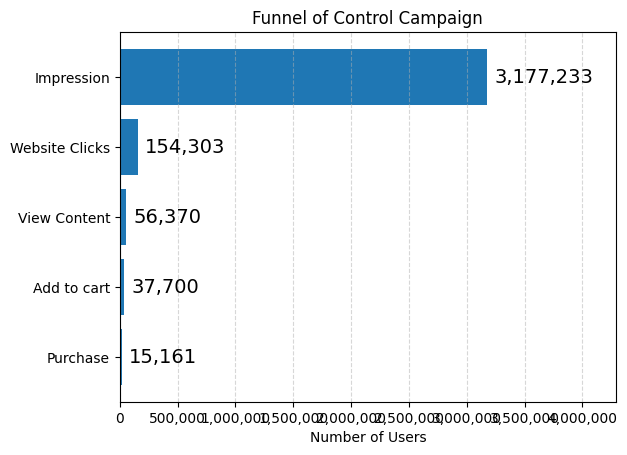

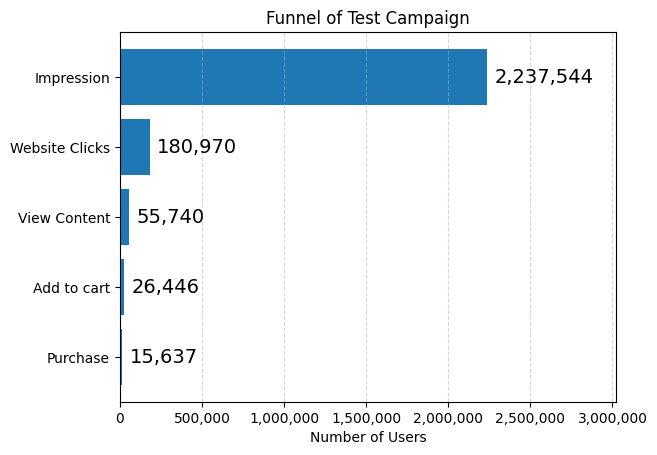

In [363]:
funnel_g(df)
funnel_g(dftest)

จากกราฟ Funnel สิ่งที่เห็นได้อย่างชัดเจนคือ 

อัตราการ Click เข้า Website หลังจากเห็นโฆษณา ใน Test Campaign มีมากกว่า Control Campaign อย่างเห็นได้ชัด

ตรงจุดนี้ทำให้บอกได้ว่า Test Campaign ทำให้คนตัดสินใจเข้า Website ได้ดีกว่า Control Campaign

ส่วนจุดอื่นๆไม่พบว่าแตกต่างกันมากนัก

## ตรวจสอบ Correlation หรือความสัมพันธ์ของตัวแปรต้น

In [366]:
def heatcorr(df):
    corr = df.iloc[:, 1:].corr()
    cname = df['Campaign Name'].iloc[0]
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", linewidths=.5,cmap="coolwarm")
    plt.title(f"Correlation Heatmap of {cname}")
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("")
    plt.ylabel("")
    plt.show()

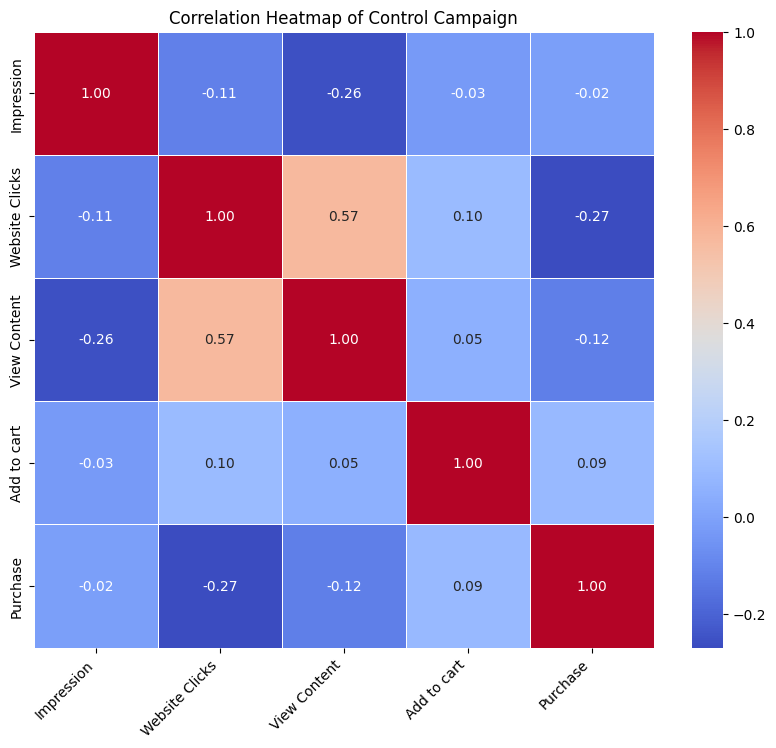

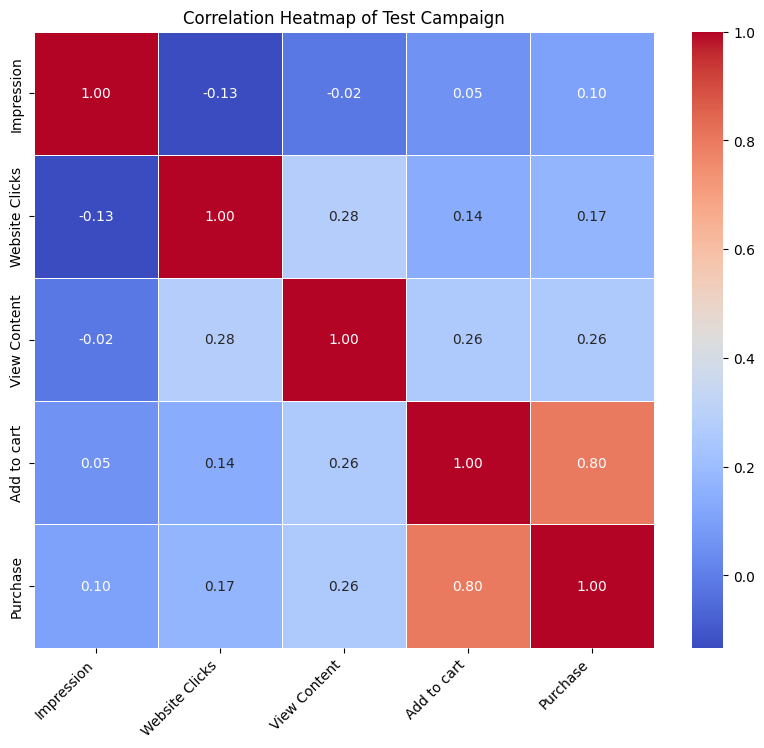

In [367]:
heatcorr(df)
heatcorr(dftest)

จาก heatmap เราจะพบว่า ใน

Control campaign : Website clicks กับ Viw Content มีความสัมพันธ์เชิงบวกกันเล็กน้อย แสดงว่าถ้าลูกค้าตัดสินใจเข้าดู website มาก ยิ่งทำให้ลูกค้าเลือกดู Content ของ Campaign มากขึ้น

Test Campaign : Add to cart กับ Purchase มีความสัมพันธ์เชิงบวกกันอย่างมาก แสดงถึงถ้าลูกค้าตัดสินใจเลือกสินค้าไว้ในใจแล้วก็จะทำให้มีโอกาสซื้อมากขึ้นอย่างมาก

ตรงจุดนี้อาจจะย้อนแย้งกับที่วิเคราะห์กราฟ Funnel แต่จริงๆแล้วให้ความหมายแตกต่างกันครับ คือ ถ้ามีความสัมพันธ์กันอย่างมากจะทำให้พยากรณ์ได้ว่าถ้าค่าใดเพิ่มอีกค่าหนึ่งก็จะเพิ่มขึ้นมาเช่นกัน แต่ไม่ได้ทำให้อัตราการของสองค่านี้เปลี่ยนไป เช่น อัตราเดิมเป็น 10:1 ค่าแรกเพิ่มขึ้นเป็น 20 ก็จะเป็น 20:2 ครับ

## Correlation XY

In [368]:
# จับข้อมูลมาทั้งสองมา Append หรือ Union กัน เพื่อนำไปใช้วิเคราะห์ต่อ
# ***หมายเหตุ ไม่จำเป็นต้องนำมารวมกัน ใช้แยกกันตามความถนัดได้ครับ
dfuni = pd.concat([df,dftest],ignore_index=True)
dfuni.head()

,Campaign Name,Impression,Website Clicks,View Content,Add to cart,Purchase
0,Control Campaign,82702.0,7016.0,2159.0,1819.0,618.0
1,Control Campaign,121040.0,8110.0,1841.0,1219.0,511.0
2,Control Campaign,131711.0,6508.0,1549.0,1134.0,372.0
3,Control Campaign,72878.0,3065.0,982.0,1183.0,340.0
4,Control Campaign,109076.0,4028.0,1249.0,784.0,764.0


In [ ]:
dfuni['Campaign label'] = dfuni['Campaign Name'].copy().replace(
    {
        'Control Campaign': 1,
        'Test Campaign': 2
    }
).infer_objects(copy=False)

C:\Users\kitak\AppData\Local\Temp\ipykernel_20940\446433395.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({


Text(0.5, 1.0, 'Correlation Between Campaign and User Behavior')

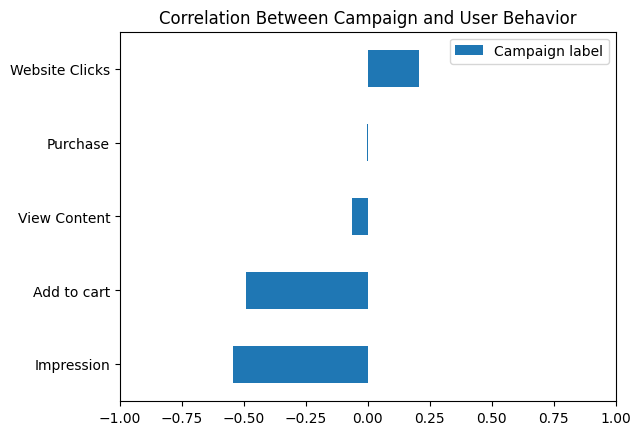

In [391]:
corr = dfuni.select_dtypes({'int','float'}).corr()
pd.DataFrame(corr["Campaign label"]).sort_values(by = 'Campaign label').iloc[:-2].plot(kind = "barh", xlim = (-1, 1)).set_title('Correlation Between Campaign and User Behavior')

จากกราฟแสดงความแสงความสัมพันธ์ของ ตัวแปรต้น และ ตัวแปรตาม

ค่าที่ > 0 แสดงว่าจะมีโอกาสมากขึ้นถ้าเป็น test Campaign

ส่วนค่าที่ < 0 แสดงว่ามีโอกาสจะมากขึ้นถ้าเป็น Control Campaign

ซึ่งจากกราฟสรุปได้ว่า Impression กับ Add to cart มีแนวโน้มจะมากกว่าถ้าเป็น Control Campaign ครับ

## ตรวจสอบการแจกแจงแบบปกติ ของข้อมูลเพื่อเตรียมให้ข้อมูลมีความเหมาะสมกับการใช้ t-test หรือ A/B testing

In [406]:
CN = 0 
NN = 0
CNlist = []
NNlist = []
for i in dfuni.select_dtypes('float'):
    stat, p = shapiro(dfuni[i])
    print('Statistic = %.3f, p = %.3f' % (stat, p))
    if p > 0.05:
        print(f"{i} is normally distributed")
        CN = CN+1
        CNlist.append(i)
    else:
        print(f"{i} is NOT normal")
        NN = NN+1
        NNlist.append(i)
    print('-'*100)
    
print(f'Normal distribution : {CN}')
print(f'Not Normal ditribution : {NN}')

Statistic = 0.953, p = 0.023
Impression is NOT normal
----------------------------------------------------------------------------------------------------
Statistic = 0.945, p = 0.010
Website Clicks is NOT normal
----------------------------------------------------------------------------------------------------
Statistic = 0.949, p = 0.015
View Content is NOT normal
----------------------------------------------------------------------------------------------------
Statistic = 0.975, p = 0.262
Add to cart is normally distributed
----------------------------------------------------------------------------------------------------
Statistic = 0.938, p = 0.005
Purchase is NOT normal
----------------------------------------------------------------------------------------------------
Normal distribution : 1
Not Normal ditribution : 4


## ทำการทดลอง Normalize เพื่อตรวจสอบว่าข้อมูลเหมาะสมสำหรับทำใน t-test หรือไม่

In [409]:
df_norm = pd.DataFrame()
for i in NNlist:
    df_norm[i] = np.log1p(dfuni[i])

Statistic = 0.894, p = 0.000
Impression is NOT normal
----------------------------------------------------------------------------------------------------


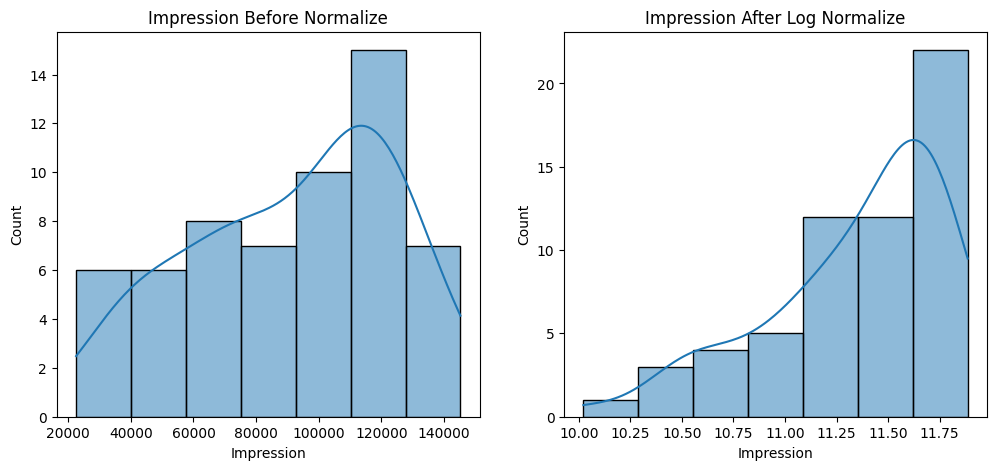

Statistic = 0.931, p = 0.002
Website Clicks is NOT normal
----------------------------------------------------------------------------------------------------


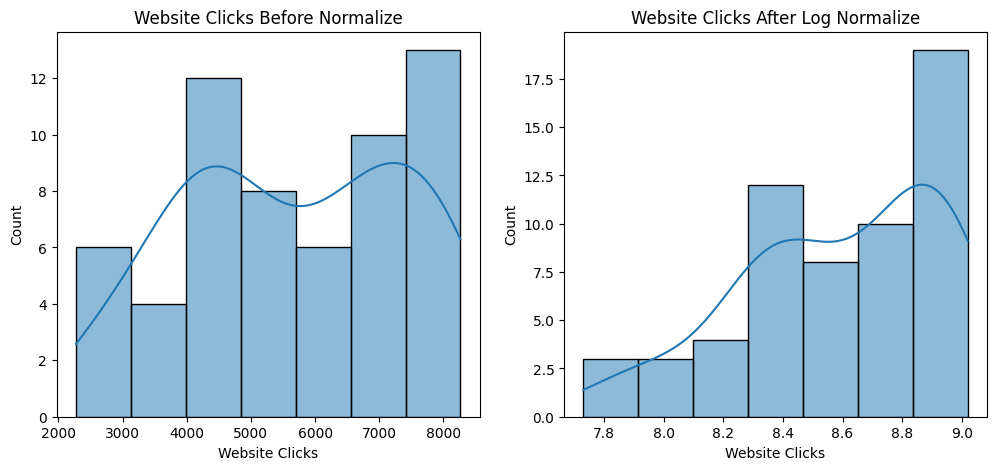

Statistic = 0.959, p = 0.047
View Content is NOT normal
----------------------------------------------------------------------------------------------------


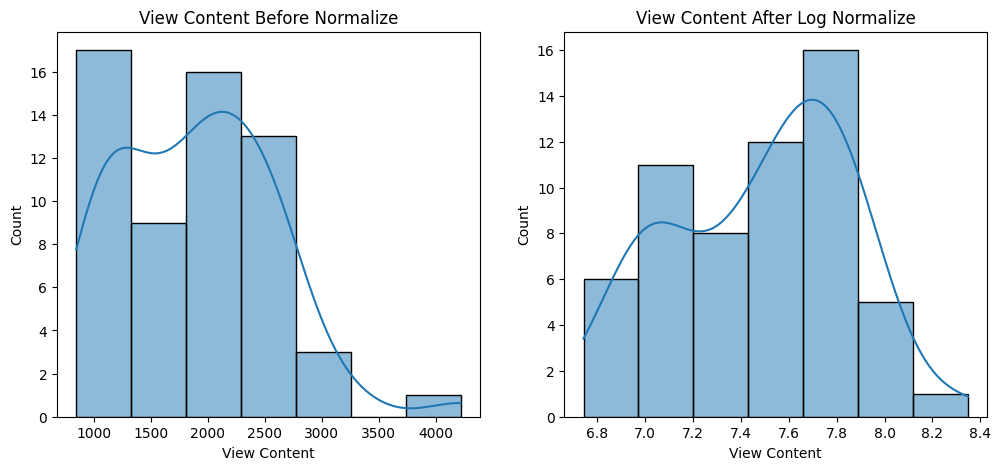

Statistic = 0.928, p = 0.002
Purchase is NOT normal
----------------------------------------------------------------------------------------------------


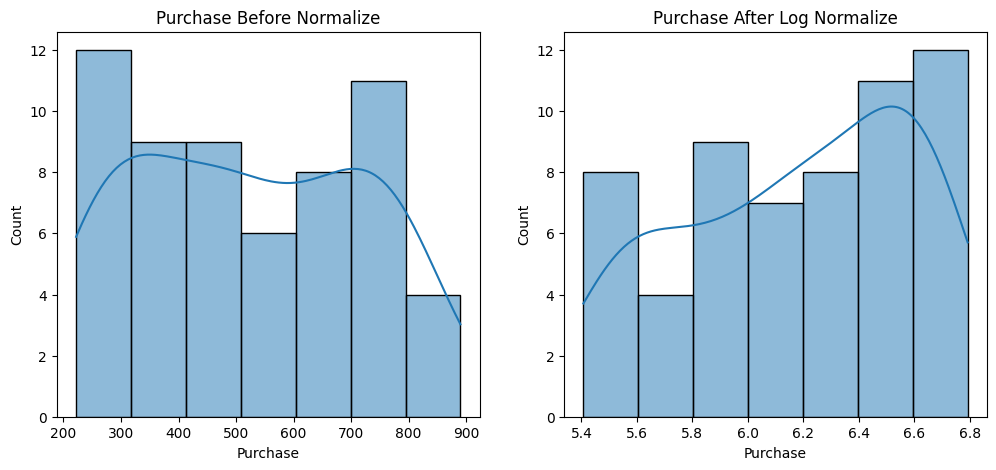

In [410]:
for i in NNlist :
    stat, p = shapiro(df_norm[i])
    print('Statistic = %.3f, p = %.3f' % (stat, p))
    if p > 0.05:
        print(f"{i} is normally distributed")
    else:
        print(f"{i} is NOT normal")
    print('-'*100)
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    sns.histplot(dfuni[i], kde=True, ax=ax[0])
    ax[0].set_title(f"{i} Before Normalize")
    sns.histplot(df_norm[i], kde=True, ax=ax[1])
    ax[1].set_title(f"{i} After Log Normalize")
    plt.show()

# <b>A/B Testing</b>
หลังจากที่ทำการ EDA แล้วพบว่าข้อมูลมีการแจกแจงแบบไม่ปกติ ส่งผลให้ไม่เหมาะกับการใช้ t-test ในการทำ A/B testing

ดังนั้นจะทำการเลือกใช้วิธีการทดสอบแบบ Non-parametric ด้วย Mann–Whitney ครับ

In [413]:
from scipy.stats import mannwhitneyu
k = 0
listoutm = []
for i in dfuni.select_dtypes('float') :
    
    A = dfuni[dfuni['Campaign Name'] == 'Control Campaign'][i]
    B = dfuni[dfuni['Campaign Name'] == 'Test Campaign'][i]
    # A และ B คือข้อมูลของ 2 กลุ่ม
    stat, p = mannwhitneyu(A, B, alternative='two-sided')
    k=k+1
    Amean = A.mean()
    Bmean = B.mean()
    print(k)
    print('Statistic = %.4f, p-value = %.4f' % (stat, p))
    print(f'สมมติฐานสำหรับ ตัวแปร *{i}* พบว่า')
    print(f"Control mean : {Amean}")
    print(f"Test mean : {Bmean}")
    if p < 0.05:
        print("Reject H0 → สองกลุ่มแตกต่างกันอย่างมีนัยสำคัญ")
        listoutm.append('H0')
    else:
        print("Fail to Reject H0 → ไม่พบความแตกต่าง")
        listoutm.append('H1')
    print('-'*70)

1
Statistic = 697.0000, p-value = 0.0001
สมมติฐานสำหรับ ตัวแปร *Impression* พบว่า
Control mean : 109559.75862068965
Test mean : 74584.8
Reject H0 → สองกลุ่มแตกต่างกันอย่างมีนัยสำคัญ
----------------------------------------------------------------------
2
Statistic = 337.0000, p-value = 0.1393
สมมติฐานสำหรับ ตัวแปร *Website Clicks* พบว่า
Control mean : 5320.793103448276
Test mean : 6032.333333333333
Fail to Reject H0 → ไม่พบความแตกต่าง
----------------------------------------------------------------------
3
Statistic = 442.0000, p-value = 0.9215
สมมติฐานสำหรับ ตัวแปร *View Content* พบว่า
Control mean : 1943.7931034482758
Test mean : 1858.0
Fail to Reject H0 → ไม่พบความแตกต่าง
----------------------------------------------------------------------
4
Statistic = 664.0000, p-value = 0.0005
สมมติฐานสำหรับ ตัวแปร *Add to cart* พบว่า
Control mean : 1300.0
Test mean : 881.5333333333333
Reject H0 → สองกลุ่มแตกต่างกันอย่างมีนัยสำคัญ
----------------------------------------------------------------

จากการใช้สถิติทดสอบสำหรับ A/B testing พบว่ามี 2 ตัวแปร ที่แตกต่างกันอย่างมีนัยยะสำคัญ สำหรับ 2 Campaigns นี้ครับ นั่นคือ

1.Impression : ฝั่ง Control Campaign มากกว่า

2.Add to cart : ฝั่ง Control Campaign มากกว่า

# <b>Conclusion</b>

จากการวิเคราะห์ A/B testing และ Correlation XY จะพบว่า Control Campaign มีแนวโน้มที่จะดีกว่า 

แต่ถ้าดูเทียบกันใน กราฟ Funnel และ Correlation ระหว่างตัวแปรต้น 

จะเห็นได้ว่าอัตราการคลิกเข้า Website หลังจากที่เห็นโฆษณา และ การซื้อหลังจากเลือกของใส่ตะกร้า ใน Test Campaign มีประสิทธิภาพมากกว่า

จะได้ว่าทั้งสอง Campaign มีจุดเด่นจุดด้อยที่แตกต่างกัน

ดังนั้น ถ้าดึงจุดที่ดึงลูกค้าเข้ามาได้มากๆจาก Control Campaign และดึงจุดที่ทำให้ Conversion Rate ของลูกค้าใน Test Campaign มารวมกันได้ก็จะสามารถสร้าง Campaign ที่แข็งแกร่งขึ้นมาได้ครับ